In [122]:
import igraph as ig
import seaborn as sns
import math
import numpy as np
from tqdm import tqdm
import scipy
import pandas as pd

In [203]:
# Initialize constants
N = 256 # Number of nodes, usually a square number
epsilon = 0.001 # Standard deviation of opinions required to terminate
trials = 1000 # Number of trials to calculate convergence time
mses_time = 100 # Number of discrete time steps to run the MSE calculations for

In [3]:
# Library config
ig.config['plotting.backend'] = 'matplotlib'

## Line graph

This graph consists of $N$ nodes in a line, where each node is connected to its two neighbors.

<AxesSubplot: >

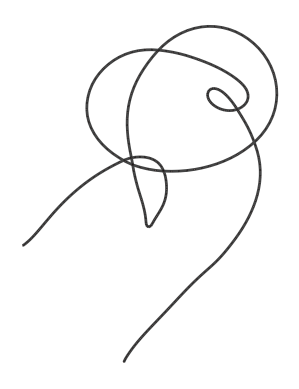

In [4]:
g_line = ig.Graph.Ring(n=N, circular=False)
ig.plot(g_line)

## Ring graph

This graph consists of $N$ nodes arranged in a ring, where each node is connected with its two neighbors.

<AxesSubplot: >

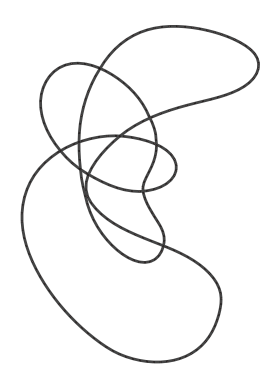

In [5]:
g_ring = ig.Graph.Ring(n=N, circular=True)
ig.plot(g_ring)

## Lattice graph

This consists of $N^2$ nodes arranged in a square lattice, where each node is connected to its four directly adjacent neighbors.

<AxesSubplot: >

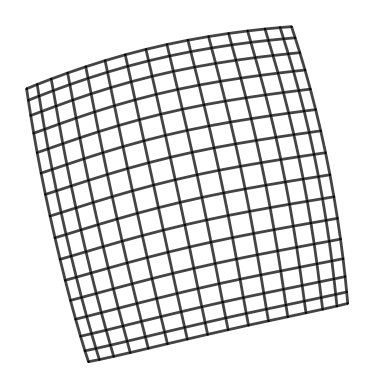

In [6]:
g_lattice = ig.Graph.Lattice(dim=[int(math.sqrt(N)), int(math.sqrt(N))], circular=False)
ig.plot(g_lattice)

## Star graph

The star graph consists of $N$ nodes, $N-1$ of which are connected to a single central node.

<AxesSubplot: >

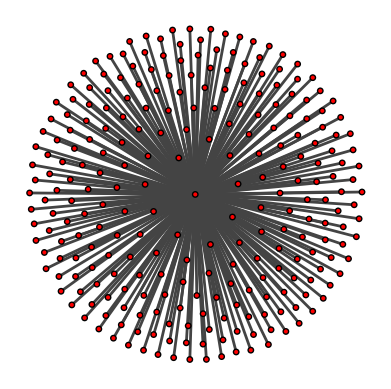

In [7]:
g_star = ig.Graph.Star(N)
ig.plot(g_star)

## Complete graph

The complete graph consists of $N$ nodes, all of which are connected to each other by $O(N^2)$ links. *[The graph is not plotted due to time constraints.]*

In [8]:
g_complete = ig.Graph.Full(N)

## Tree graph
The tree graph consists of a root node, with each node having a set number of "children" to which it is connected.

<AxesSubplot: >

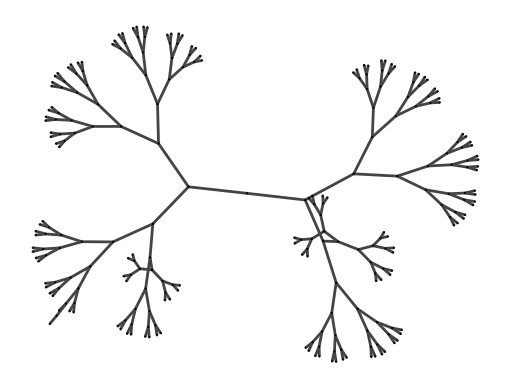

In [9]:
g_tree = ig.Graph.Tree(n=N, children=2)
ig.plot(g_tree)

## Barabási-Albert (BA) model

The Barabási-Albert model is a method for generating scale-free and connected graphs, adding new nodes and linking them to nodes with a probability proportional to their degree.

<AxesSubplot: >

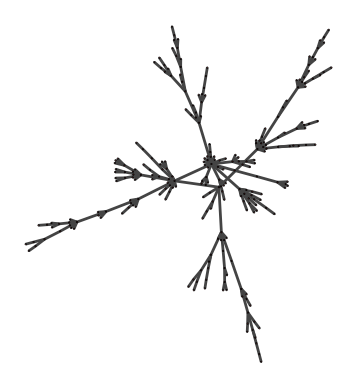

In [10]:
g_ba = ig.Graph.Barabasi(n=N, m=1)
ig.plot(g_ba)

## Watts-Strogatz (WS) model

<AxesSubplot: >

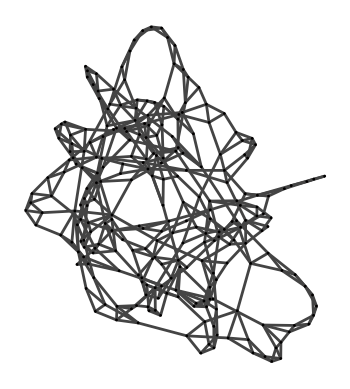

In [11]:
g_ws = ig.Graph.Watts_Strogatz(dim=1, size=N, nei=2, p=0.05)
ig.plot(g_ws)

# Developing the consensus algorithm

In [105]:
def get_unweighted_matrix(g_):
    adj = np.array(g_.get_adjacency().data)
    np.fill_diagonal(adj, 1)
    return (adj / np.linalg.norm(adj, axis=1, ord=1).reshape((N,1))).T

def get_max_unweighted_eigenvalue(g_):
    adj = get_unweighted_matrix(g_)
    eig, vecsr = scipy.linalg.eig(adj)
    eigmax = np.argmax(eig)

    return np.array(vecsr[:,eigmax]) / np.sum(vecsr[:,eigmax])

def convergence_value(ev, initial_opinions):
    return ev.dot(initial_opinions)

def time_to_convergence_unweighted(g_, epsilon=epsilon, trials=trials):
    adj = get_unweighted_matrix(g_)
    ev = get_max_unweighted_eigenvalue(g_)
    
    ts = []
    for _ in tqdm(range(trials)):
        # assign uniformly random initial preferences on [0,1)
        opinions = np.random.rand(N)
        ucv = convergence_value(ev, opinions).real

        _mse = lambda op: np.square(np.subtract(op, ucv)).mean()

        t = 0
        while(_mse(opinions) > epsilon):
            opinions = opinions.dot(adj) # matrix multiplication of modified normalized adjacency matrix with opinion vector
            t += 1
        
        ts.append(t)
    
    return ts

def get_mses_unweighted(g_, max_t=mses_time, trials=trials):
    adj = get_unweighted_matrix(g_)
    ev = get_max_unweighted_eigenvalue(g_)
    
    mses = []
    for _ in tqdm(range(trials)):
        # assign uniformly random initial preferences on [0,1)
        opinions = np.random.rand(N)
        ucv = convergence_value(ev, opinions).real

        _mse = lambda op: np.square(np.subtract(op, ucv)).mean()
        int_mses = []

        for _ in range(max_t):
            int_mses.append(_mse(opinions))
            opinions = opinions.dot(adj) # matrix multiplication of modified normalized adjacency matrix with opinion vector

        mses.append(int_mses)
    
    return mses

In [223]:
def get_weighted_matrix(g_):
    adj = np.array(g_.get_adjacency().data)
    degree = np.array(g_.degree())
    np.fill_diagonal(adj, 1)
    adj = adj * degree # weight by degree
    return (adj / np.linalg.norm(adj, axis=1, ord=1).reshape((N,1))).T


def get_max_weighted_eigenvalue(g_):
    adj = get_weighted_matrix(g_)
    eig, vecsr = scipy.linalg.eig(adj)
    eigmax = np.argmax(eig)

    return np.array(vecsr[:,eigmax]) / np.sum(vecsr[:,eigmax])

def time_to_convergence_weighted(g_, epsilon=epsilon):
    adj = get_weighted_matrix(g_)
    ev = get_max_weighted_eigenvalue(g_)
    
    ts = []
    for _ in tqdm(range(trials)):
        # assign uniformly random initial preferences on [0,1)
        opinions = np.random.rand(N)
        ucv = convergence_value(ev, opinions).real

        _mse = lambda op: np.square(np.subtract(op, ucv)).mean()

        t = 0
        while(_mse(opinions) > epsilon):
            opinions = opinions.dot(adj) # matrix multiplication of modified normalized adjacency matrix with opinion vector
            t += 1

        ts.append(t)
    
    return ts

def get_mses_weighted(g_, max_t=mses_time, trials=trials):
    adj = get_weighted_matrix(g_)
    ev = get_max_weighted_eigenvalue(g_)
    
    mses = []
    for _ in tqdm(range(trials)):
        # assign uniformly random initial preferences on [0,1)
        opinions = np.random.rand(N)
        ucv = convergence_value(ev, opinions).real

        _mse = lambda op: np.square(np.subtract(op, ucv)).mean()
        int_mses = []

        for _ in range(max_t):
            int_mses.append(_mse(opinions))
            opinions = opinions.dot(adj) # matrix multiplication of modified normalized adjacency matrix with opinion vector

        mses.append(int_mses)
    
    return mses

In [51]:
def time_to_convergence_weighted_discrete(g_, epsilon=epsilon):
    adj = np.array(g_.get_adjacency().data)
    degree = np.array(g_.degree())
    np.fill_diagonal(adj, 1)
    adj = adj * degree # weight by degree
    adj = adj / np.linalg.norm(adj, axis=1, ord=1).reshape((N,1))
    
    # assign uniformly random initial preferences on [0,1)
    opinions = np.round(np.random.rand(N))

    t = 0
    while(np.abs(0.5 - np.average(opinions)) < 0.4): # (average opinion) is in (0.1, 0.9)
        opinions = np.round(np.dot(adj, opinions)) # matrix multiplication of modified normalized adjacency matrix with opinion vector
        t += 1
        if(t > 1000): # convergence might not be achieved at all due to oscillations
            break
    
    return t

### Calculating time-to-consensus (TTC) values

In [47]:
t_line_uw = time_to_convergence_unweighted(g_line)
t_ring_uw = time_to_convergence_unweighted(g_ring)
t_lattice_uw = time_to_convergence_unweighted(g_lattice)
t_star_uw = time_to_convergence_unweighted(g_star)
t_complete_uw = time_to_convergence_unweighted(g_complete)
t_ba_uw = time_to_convergence_unweighted(g_ba)
t_ws_uw = time_to_convergence_unweighted(g_ws)
t_tree_uw = time_to_convergence_unweighted(g_tree)


100%|██████████| 1000/1000 [00:03<00:00, 302.76it/s]


In [106]:
mses_line_uw = get_mses_unweighted(g_line)
mses_ring_uw = get_mses_unweighted(g_ring)
mses_lattice_uw = get_mses_unweighted(g_lattice)
mses_star_uw = get_mses_unweighted(g_star)
mses_complete_uw = get_mses_unweighted(g_complete)
mses_ba_uw = get_mses_unweighted(g_ba)
mses_ws_uw = get_mses_unweighted(g_ws)
mses_tree_uw = get_mses_unweighted(g_tree)

100%|██████████| 1000/1000 [00:01<00:00, 543.06it/s]


In [64]:
t_line_w = time_to_convergence_weighted(g_line, epsilon=0.005)
t_ring_w = time_to_convergence_weighted(g_ring, epsilon=0.005)
t_lattice_w = time_to_convergence_weighted(g_lattice, epsilon=0.005)
t_star_w = time_to_convergence_weighted(g_star, epsilon=0.005)
t_complete_w = time_to_convergence_weighted(g_complete, epsilon=0.005)
t_ba_w = time_to_convergence_weighted(g_ba, epsilon=0.005)
t_ws_w = time_to_convergence_weighted(g_ws, epsilon=0.005)
t_tree_w = time_to_convergence_weighted(g_tree, epsilon=0.005)


100%|██████████| 1000/1000 [00:00<00:00, 1457.04it/s]


In [224]:
mses_line_w = get_mses_weighted(g_line)
mses_ring_w = get_mses_weighted(g_ring)
mses_lattice_w = get_mses_weighted(g_lattice)
mses_star_w = get_mses_weighted(g_star)
mses_complete_w = get_mses_weighted(g_complete)
mses_ba_w = get_mses_weighted(g_ba)
mses_ws_w = get_mses_weighted(g_ws)
mses_tree_w = get_mses_weighted(g_tree)

100%|██████████| 1000/1000 [00:03<00:00, 316.01it/s]


In [57]:
t_line_wd = [time_to_convergence_weighted_discrete(g_line) for _ in tqdm(range(trials))]
t_ring_wd = [time_to_convergence_weighted_discrete(g_ring) for _ in tqdm(range(trials))]
t_lattice_wd = [time_to_convergence_weighted_discrete(g_lattice) for _ in tqdm(range(trials))]
t_star_wd = [time_to_convergence_weighted_discrete(g_star) for _ in tqdm(range(trials))]
t_complete_wd = [time_to_convergence_weighted_discrete(g_complete) for _ in tqdm(range(trials))]
t_ba_wd = [time_to_convergence_weighted_discrete(g_ba) for _ in tqdm(range(trials))]
t_ws_wd = [time_to_convergence_weighted_discrete(g_ws) for _ in tqdm(range(trials))]
t_tree_wd = [time_to_convergence_weighted_discrete(g_ws) for _ in tqdm(range(trials))]





















































































































































































































































































































































































































































































100%|██████████| 1000/1000 [00:29<00:00, 33.55it/s]






































































































































































































































































































































































































































































100%|██████████| 1000/1000 

### Histograms of TTC

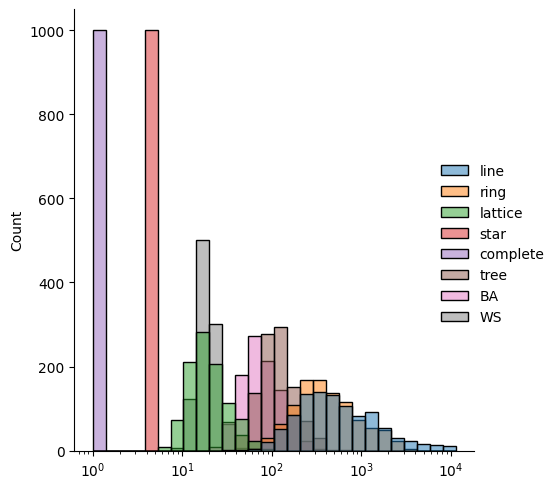

In [48]:
# https://stackoverflow.com/questions/36362624/how-to-plot-multiple-histograms-on-same-plot-with-seaborn
# https://stackoverflow.com/questions/45201514/how-to-edit-a-seaborn-legend-title-and-labels-for-figure-level-functions

hist_uw = sns.displot([t_line_uw, t_ring_uw, t_lattice_uw, t_star_uw, t_complete_uw, t_tree_uw, t_ba_uw, t_ws_uw], log_scale=True)

labels = ['line', 'ring', 'lattice', 'star', 'complete', 'tree', 'BA', 'WS']
for t, l in zip(hist_uw._legend.texts, labels):
    t.set_text(l)

In [211]:
def df_to_pairs(df):
    pairs = []
    for _, data in df.iterrows():
        for index, value in enumerate(data):
            pairs.append((index, value))
    
    return np.array(pairs).T.tolist()

mses_line_uw_df = df_to_pairs(pd.DataFrame(mses_line_uw))
mses_ring_uw_df = df_to_pairs(pd.DataFrame(mses_ring_uw))
mses_lattice_uw_df = df_to_pairs(pd.DataFrame(mses_lattice_uw))
mses_star_uw_df = df_to_pairs(pd.DataFrame(mses_star_uw))
mses_complete_uw_df = df_to_pairs(pd.DataFrame(mses_complete_uw))
mses_tree_uw_df = df_to_pairs(pd.DataFrame(mses_tree_uw))
mses_ba_uw_df = df_to_pairs(pd.DataFrame(mses_ba_uw))
mses_ws_uw_df = df_to_pairs(pd.DataFrame(mses_ws_uw))

df_length = mses_time * trials

lp_uw_df = pd.DataFrame({
    "time": mses_line_uw_df[0] * 8,
    "mse": mses_line_uw_df[1] + mses_ring_uw_df[1] + mses_lattice_uw_df[1] + mses_star_uw_df[1] + mses_complete_uw_df[1] + mses_tree_uw_df[1] + mses_ba_uw_df[1] + mses_ws_uw_df[1],
    "graph": ["line"] * df_length + ["ring"] * df_length + ["lattice"] * df_length + ["star"] * df_length + ["complete"] * df_length + ["tree"] * df_length + ["BA"] * df_length + ["WS"] * df_length
})

lp_uw_df

,time,mse,graph
0,0.0,0.085751,line
1,1.0,0.030517,line
2,2.0,0.021802,line
3,3.0,0.017796,line
4,4.0,0.015307,line
...,...,...,...
799995,95.0,0.000042,WS
799996,96.0,0.000041,WS
799997,97.0,0.000039,WS
799998,98.0,0.000038,WS


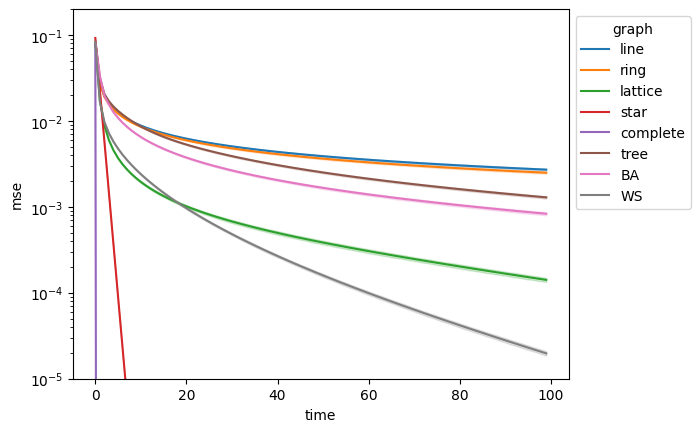

In [221]:
line_uw = sns.lineplot(data=lp_uw_df, x="time", y="mse", errorbar=("ci", 95), hue="graph")
# line_uw.set(xscale='log')
line_uw.set(yscale='log')
line_uw.set(ylim=(10e-6,2e-1))
sns.move_legend(line_uw, "upper left", bbox_to_anchor=(1, 1))

  0%|          | 0/1000 [07:24<?, ?it/s]


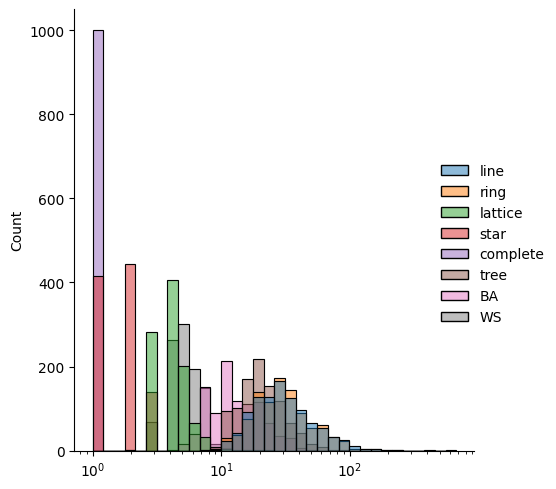

In [66]:
hist_w = sns.displot([t_line_w, t_ring_w, t_lattice_w, t_star_w, t_complete_w, t_tree_w, t_ba_w, t_ws_w], log_scale=True)

labels = ['line', 'ring', 'lattice', 'star', 'complete', 'tree', 'BA', 'WS']
for t, l in zip(hist_w._legend.texts, labels):
    t.set_text(l)

In [225]:
mses_line_w_df = df_to_pairs(pd.DataFrame(mses_line_w))
mses_ring_w_df = df_to_pairs(pd.DataFrame(mses_ring_w))
mses_lattice_w_df = df_to_pairs(pd.DataFrame(mses_lattice_w))
mses_star_w_df = df_to_pairs(pd.DataFrame(mses_star_w))
mses_complete_w_df = df_to_pairs(pd.DataFrame(mses_complete_w))
mses_tree_w_df = df_to_pairs(pd.DataFrame(mses_tree_w))
mses_ba_w_df = df_to_pairs(pd.DataFrame(mses_ba_w))
mses_ws_w_df = df_to_pairs(pd.DataFrame(mses_ws_w))

df_length = mses_time * trials

lp_w_df = pd.DataFrame({
    "time": mses_line_w_df[0] * 8,
    "mse": mses_line_w_df[1] + mses_ring_w_df[1] + mses_lattice_w_df[1] + mses_star_w_df[1] + mses_complete_w_df[1] + mses_tree_w_df[1] + mses_ba_w_df[1] + mses_ws_w_df[1],
    "graph": ["line"] * df_length + ["ring"] * df_length + ["lattice"] * df_length + ["star"] * df_length + ["complete"] * df_length + ["tree"] * df_length + ["BA"] * df_length + ["WS"] * df_length
})

lp_w_df

,time,mse,graph
0,0.0,0.085818,line
1,1.0,0.033493,line
2,2.0,0.023125,line
3,3.0,0.018211,line
4,4.0,0.015133,line
...,...,...,...
799995,95.0,0.000003,WS
799996,96.0,0.000003,WS
799997,97.0,0.000003,WS
799998,98.0,0.000003,WS


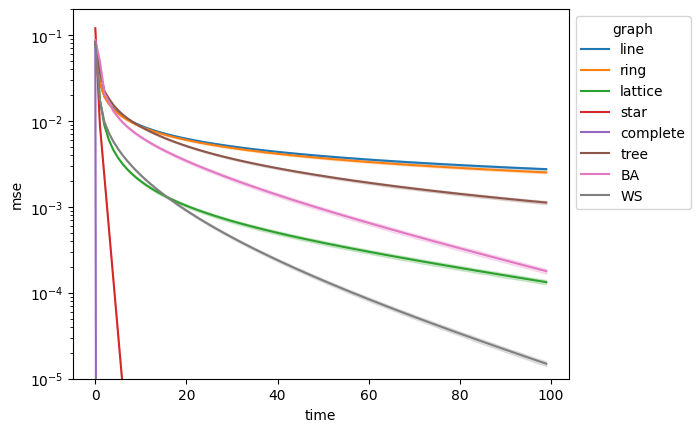

In [226]:
line_uw = sns.lineplot(data=lp_w_df, x="time", y="mse", errorbar=("ci", 95), hue="graph")
# line_uw.set(xscale='log')
line_uw.set(yscale='log')
line_uw.set(ylim=(10e-6,2e-1))
sns.move_legend(line_uw, "upper left", bbox_to_anchor=(1, 1))

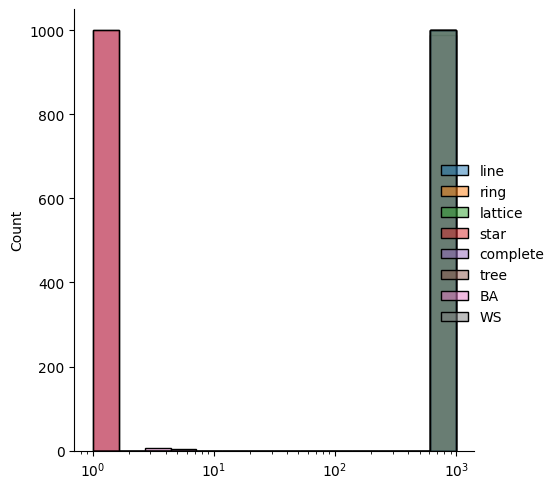

In [68]:
hist_wd = sns.displot([t_line_wd, t_ring_wd, t_lattice_wd, t_star_wd, t_complete_wd, t_tree_wd, t_ba_wd, t_ws_wd], log_scale=True)

labels = ['line', 'ring', 'lattice', 'star', 'complete', 'tree', 'BA', 'WS']
for t, l in zip(hist_wd._legend.texts, labels):
    t.set_text(l)

## Statistical analysis

### Average time to sufficient convergence

In [41]:
print("line average:", np.average(t_line_uw)) # information is bad
print("ring average:", np.average(t_ring_uw)) # line of half the length, but you add only one edge
print("lattice average:", np.average(t_lattice_uw)) # reduced to maximum distance as L1-norm from (0,0) to (N,N) = 2N
print("star average:", np.average(t_star_uw)) # mathematically provable
print("complete average:", np.average(t_complete_uw)) # mathematically provable
print("tree average:", np.average(t_tree_uw)) # mathematically provable
print("BA average:", np.average(t_ba_uw))
print("WS average:", np.average(t_ws_uw))

line average: 56.442
ring average: 55.863
lattice average: 5.38
star average: 3.0
complete average: 1.0
tree average: 30.475
BA average: 20.636
WS average: 6.567


In [71]:
print("line average (weighted):", np.average(t_line_w)) # information is bad
print("ring average (weighted):", np.average(t_ring_w)) # line of half the length, but you add only one edge
print("lattice average (weighted):", np.average(t_lattice_w)) # reduced to maximum distance as L1-norm from (0,0) to (N,N) = 2N
print("star average (weighted):", np.average(t_star_w)) # mathematically provable
print("complete average (weighted):", np.average(t_complete_w)) # mathematically provable
print("tree average (weighted):", np.average(t_tree_w)) # mathematically provable
print("BA average (weighted):", np.average(t_ba_w))
print("WS average (weighted):", np.average(t_ws_w))

line average (weighted): 408.957
ring average (weighted): 292.67
lattice average (weighted): 14.171
star average (weighted): 1.0
complete average (weighted): 1.0
tree average (weighted): 75.551
BA average (weighted): 27.167
WS average (weighted): 16.746


## Eigenvalue calculations

In [25]:
opinions = np.random.rand(N)

In [67]:
print(np.linalg.matrix_power(get_weighted_matrix(g_star), 1))

[[0.5        0.99609375 0.99609375 ... 0.99609375 0.99609375 0.99609375]
 [0.00196078 0.00390625 0.         ... 0.         0.         0.        ]
 [0.00196078 0.         0.00390625 ... 0.         0.         0.        ]
 ...
 [0.00196078 0.         0.         ... 0.00390625 0.         0.        ]
 [0.00196078 0.         0.         ... 0.         0.00390625 0.        ]
 [0.00196078 0.         0.         ... 0.         0.         0.00390625]]


In [326]:
adj = np.array(ig.Graph.Ring(n=5,circular=True).get_adjacency().data)
np.fill_diagonal(adj, 1)
adj2 = (adj / np.linalg.norm(adj, axis=1, ord=1).reshape((5,1))).T
eig, vecsl, vecsr = scipy.linalg.eig(adj2, left=True)
eigmax = np.argmax(eig)

(vecsr[:,eigmax] / np.sum(vecsr[:,eigmax])).dot([0.5,0.6,0.5,0.5,0.5])

0.52

In [314]:
adj = np.array(g_ws.get_adjacency().data)
np.fill_diagonal(adj, 1)
adj2 = (adj / np.linalg.norm(adj, axis=1, ord=1).reshape((N,1))).T
eig, vecsl, vecsr = scipy.linalg.eig(adj2, left=True)
eigmax = np.argmax(eig)
scale = 1 / np.dot(vecsr[:,eigmax],vecsl[:,eigmax])

eig[eigmax], scale, opinions.dot(scale * np.outer(vecsr[:,eigmax], vecsl[:,eigmax])), (vecsr[:,eigmax]/np.linalg.norm(vecsr[:,eigmax],1)).dot(opinions)

((1.0000000000000002+0j),
 1.0062305898749055,
 array([0.49196813, 0.49196813, 0.49196813, 0.49196813, 0.49196813,
        0.49196813, 0.49196813, 0.49196813, 0.49196813, 0.49196813,
        0.49196813, 0.49196813, 0.49196813, 0.49196813, 0.49196813,
        0.49196813, 0.49196813, 0.49196813, 0.49196813, 0.49196813,
        0.49196813, 0.49196813, 0.49196813, 0.49196813, 0.49196813,
        0.49196813, 0.49196813, 0.49196813, 0.49196813, 0.49196813,
        0.49196813, 0.49196813, 0.49196813, 0.49196813, 0.49196813,
        0.49196813, 0.49196813, 0.49196813, 0.49196813, 0.49196813,
        0.49196813, 0.49196813, 0.49196813, 0.49196813, 0.49196813,
        0.49196813, 0.49196813, 0.49196813, 0.49196813, 0.49196813,
        0.49196813, 0.49196813, 0.49196813, 0.49196813, 0.49196813,
        0.49196813, 0.49196813, 0.49196813, 0.49196813, 0.49196813,
        0.49196813, 0.49196813, 0.49196813, 0.49196813, 0.49196813,
        0.49196813, 0.49196813, 0.49196813, 0.49196813, 0.49196813,
 